In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models
import os
import matplotlib.pyplot as plt

In [2]:
# === 1. Configuration ===
IMG_SIZE = 224
BATCH_SIZE = 16
AUTOTUNE = tf.data.AUTOTUNE
EPOCHS_HEAD = 5
EPOCHS_FINE = 25
LEARNING_RATE_HEAD = 1e-3
LEARNING_RATE_FINE = 1e-4

In [3]:
# Directories
train_dir = '/content/drive/MyDrive/Colab Notebooks/final project stanford car fine tuning/car_data/train'
test_dir = '/content/drive/MyDrive/Colab Notebooks/final project stanford car fine tuning/car_data/test'

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
# === 2. Load datasets ===
train_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    batch_size=BATCH_SIZE,
    image_size=(IMG_SIZE, IMG_SIZE),
    label_mode='categorical',
    shuffle=True
)
val_ds = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    batch_size=BATCH_SIZE,
    image_size=(IMG_SIZE, IMG_SIZE),
    label_mode='categorical',
    shuffle=False
)

num_classes = len(train_ds.class_names)
print(f"Detected {num_classes} classes.")

Found 12084 files belonging to 196 classes.
Found 4131 files belonging to 196 classes.
Detected 196 classes.


In [6]:
# Prefetch for performance
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)

In [7]:
# === 3. Preprocessing ===
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

def process(image, label):
    image = preprocess_input(image)
    return image, label

train_ds = train_ds.map(process)
val_ds = val_ds.map(process)

In [8]:
# === 4. Build model ===
base_model = tf.keras.applications.MobileNetV2(
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
    include_top=False,
    weights='imagenet'
)
base_model.trainable = False  # Freeze the convolutional base

inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
x = base_model(inputs, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.2)(x)
outputs = layers.Dense(num_classes, activation='softmax')(x)
model = models.Model(inputs, outputs)

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE_HEAD),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 196)            │       251,076 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,509,060 (9.57 MB)

 Trainable params: 251,076 (980.77 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [9]:
# === 5. Train classifier head ===
history1 = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS_HEAD
)

Epoch 1/5
756/756 ━━━━━━━━━━━━━━━━━━━━ 2817s 4s/step - accuracy: 0.1078 - loss: 4.4545 - val_accuracy: 0.3145 - val_loss: 2.8992
Epoch 2/5
756/756 ━━━━━━━━━━━━━━━━━━━━ 132s 134ms/step - accuracy: 0.4912 - loss: 2.1265 - val_accuracy: 0.3786 - val_loss: 2.5381
Epoch 3/5
756/756 ━━━━━━━━━━━━━━━━━━━━ 125s 112ms/step - accuracy: 0.6232 - loss: 1.5751 - val_accuracy: 0.4060 - val_loss: 2.3701
Epoch 4/5
756/756 ━━━━━━━━━━━━━━━━━━━━ 138s 106ms/step - accuracy: 0.7004 - loss: 1.2461 - val_accuracy: 0.4374 - val_loss: 2.2587
Epoch 5/5
756/756 ━━━━━━━━━━━━━━━━━━━━ 83s 108ms/step - accuracy: 0.7622 - loss: 1.0172 - val_accuracy: 0.4464 - val_loss: 2.2155


In [10]:
# === 6. Fine-tune top layers ===
base_model.trainable = True

# Freeze all but last N layers, or keep batch-norm layers frozen
fine_tune_at = len(base_model.layers) - 50
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE_FINE),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history2 = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS_HEAD + EPOCHS_FINE,
    initial_epoch=history1.epoch[-1]
)

Epoch 5/30
756/756 ━━━━━━━━━━━━━━━━━━━━ 133s 148ms/step - accuracy: 0.4962 - loss: 2.1187 - val_accuracy: 0.4757 - val_loss: 2.2484
Epoch 6/30
756/756 ━━━━━━━━━━━━━━━━━━━━ 104s 111ms/step - accuracy: 0.8246 - loss: 0.6231 - val_accuracy: 0.5914 - val_loss: 1.6033
Epoch 7/30
756/756 ━━━━━━━━━━━━━━━━━━━━ 84s 111ms/step - accuracy: 0.9091 - loss: 0.3248 - val_accuracy: 0.6347 - val_loss: 1.3981
Epoch 8/30
756/756 ━━━━━━━━━━━━━━━━━━━━ 108s 143ms/step - accuracy: 0.9533 - loss: 0.1939 - val_accuracy: 0.6662 - val_loss: 1.3226
Epoch 9/30
756/756 ━━━━━━━━━━━━━━━━━━━━ 84s 110ms/step - accuracy: 0.9656 - loss: 0.1425 - val_accuracy: 0.6797 - val_loss: 1.2734
Epoch 10/30
756/756 ━━━━━━━━━━━━━━━━━━━━ 141s 109ms/step - accuracy: 0.9737 - loss: 0.1101 - val_accuracy: 0.6623 - val_loss: 1.3871
Epoch 11/30
756/756 ━━━━━━━━━━━━━━━━━━━━ 105s 138ms/step - accuracy: 0.9758 - loss: 0.1083 - val_accuracy: 0.6676 - val_loss: 1.4259
Epoch 12/30
756/756 ━━━━━━━━━━━━━━━━━━━━ 82s 108ms/step - accuracy: 0.9770 -

In [11]:
# === 8. Evaluate ===
loss, acc = model.evaluate(val_ds)
print(f"Final accuracy: {acc:.4f}")

259/259 ━━━━━━━━━━━━━━━━━━━━ 20s 76ms/step - accuracy: 0.6650 - loss: 1.5807
Final accuracy: 0.6901


In [12]:
import os
from tensorflow.keras.models import load_model
from google.colab import files

save_dir = "/content/drive/MyDrive/Colab Notebooks/final project stanford car fine tuning"
os.makedirs(save_dir, exist_ok=True)
model_path = os.path.join(save_dir, "mobilenet_model.keras")
model.save(model_path)

In [13]:
# === 9. Plot training curves ===
def plot_training_history(history_list):
    """
    Plots training & validation accuracy/loss from a list of Keras History objects.
    Useful if training was done in stages.
    """
    acc = []
    val_acc = []
    loss = []
    val_loss = []

    for hist in history_list:
        acc += hist.history['accuracy']
        val_acc += hist.history['val_accuracy']
        loss += hist.history['loss']
        val_loss += hist.history['val_loss']

    epochs_range = range(1, len(acc) + 1)

    plt.figure(figsize=(14, 5))

    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Train Accuracy')
    plt.plot(epochs_range, val_acc, label='Val Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Train Loss')
    plt.plot(epochs_range, val_loss, label='Val Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')

    plt.tight_layout()
    plt.show()


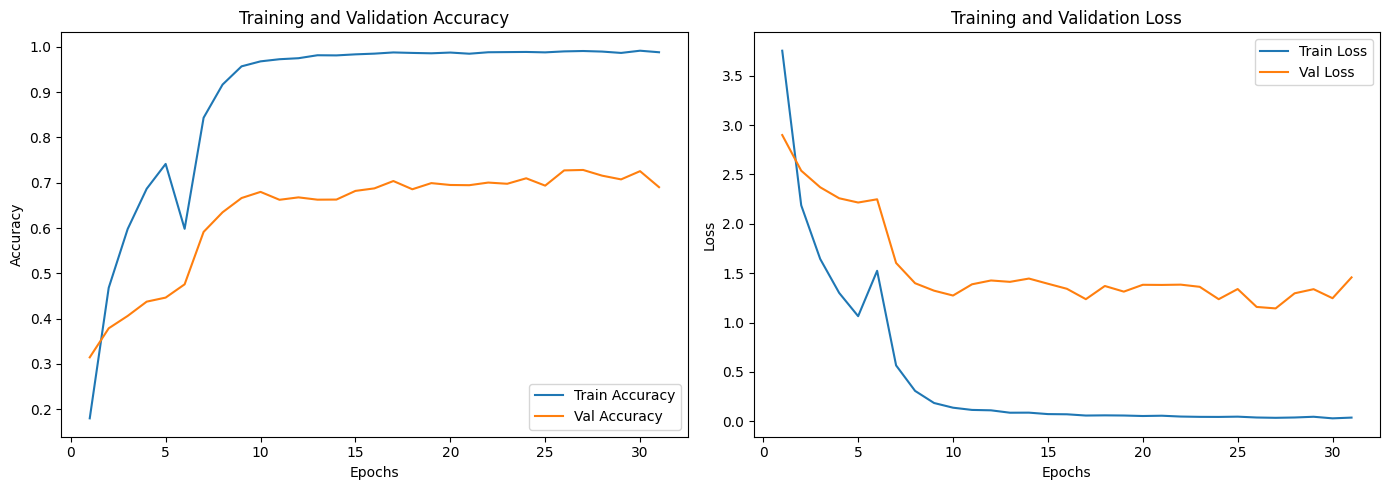

In [14]:
plot_training_history([history1, history2])
